In [ ]:
 ! pip install -q kaggle

In [ ]:
from google.colab import files 

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mahatasim","key":"e14b2c73b334b4f3f5260c312def22ff"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

 99% 737M/745M [00:13<00:00, 78.7MB/s]
100% 745M/745M [00:13<00:00, 59.4MB/s]


In [ ]:
! unzip covid19-radiography-database.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6710.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6711.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6712.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6713.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6714.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6715.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6716.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6717.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6718.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6719.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-672.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6720.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6721.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6722.png  
  inflating:

In [ ]:
# Importing necessary libraries
import os
import shutil
import random
import torch
import torchvision
import numpy as np
from torchvision import transforms
from torchvision import datasets

from PIL import Image
from matplotlib import pyplot as plt

In [ ]:
# manual_seed sets the random seed from pytorch random number generators
torch.manual_seed(0)

In [ ]:
# Preparing data for training and testing
from distutils.dir_util import copy_tree

directory = './COVID-19_Radiography_Dataset'

source_dirs = ['COVID', 'Lung_Opacity','Normal','Viral Pneumonia']
 
input_dir = './train'
output_dir = './test'

normal_dir = './COVID-19_Radiography_Dataset/Normal'
covid_dir = './COVID-19_Radiography_Dataset/COVID'
viral_dir = './COVID-19_Radiography_Dataset/Viral Pneumonia'
opacity_dir = './COVID-19_Radiography_Dataset/Lung_Opacity'

In [ ]:
! ls

covid19-radiography-database.zip  kaggle.json
COVID-19_Radiography_Dataset	  sample_data


In [ ]:
if os.path.isdir(os.path.join(directory, source_dirs[1])):
  if not os.path.isdir(input_dir):
    os.mkdir(input_dir)
    # Creating train directory
    
    #Copy classes to train
    copy_tree(normal_dir, input_dir + '/Normal')
    copy_tree(viral_dir, input_dir +'/Viral Pneumonia')
    copy_tree(covid_dir,input_dir + '/COVID')
    copy_tree(opacity_dir, input_dir + '/Lung_Opacity')

  #Create test directory
  if not os.path.isdir(output_dir):
    os.mkdir(output_dir)
  
  for c in source_dirs:
    if not os.path.isdir(os.path.join(output_dir,c)):
      os.mkdir(os.path.join(output_dir,c))
      #Creating test dir classes
  
  for c in source_dirs:
    images = [x for x in os.listdir(os.path.join(input_dir,c))
    if x.lower().endswith('png')]

    selected_images = random.sample(images,30)
    for image in selected_images:
      source_path = os.path.join(input_dir,c,image)
      target_path = os.path.join(output_dir, c, image)
      shutil.move(source_path, target_path)

In [ ]:
# def pil_loader(path):
#     with open(path, 'rb') as f:
#         img = Image.open(f)
#         return img.convert('RGB')

In [ ]:
# Writing custom Dataset
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['Normal', 'Viral Pneumonia', 'COVID', 'Lung_Opacity']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

In [ ]:
#Creating a Transformation Object for training 
train_transform = torchvision.transforms.Compose([
    #Converting images to the size that the model expects
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.RandomHorizontalFlip(), #A RandomHorizontalFlip to augment our data
    torchvision.transforms.ToTensor(), #Converting to tensor
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                    std = [0.229, 0.224, 0.225]) #Normalizing the data to the data that the ResNet18 was trained on
    
])

In [ ]:
#Creating a Transformation Object for testing
test_transform = torchvision.transforms.Compose([
    #Converting images to the size that the model expects
    torchvision.transforms.Resize(size=(224,224)),
# We don't do data augmentation in the test/val set    
    torchvision.transforms.ToTensor(), #Converting to tensor
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                    std = [0.229, 0.224, 0.225]) #Normalizing the data to the data that the ResNet18 was trained on
    
])

In [ ]:
# train_dataset = datasets.ImageFolder("./train/", transform=train_transform, loader=pil_loader)

In [ ]:
# test_dataset = torchvision.datasets.ImageFolder("./test/", transform = test_transform, loader=pil_loader)

In [ ]:
train_dirs = {
    'Normal': input_dir + '/Normal',
    'Viral Pneumonia': input_dir + '/Viral Pneumonia',
    'COVID': input_dir + '/COVID',
    'Lung_Opacity':input_dir + '/Lung_Opacity'
}
train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 10162 Normal examples
Found 1315 Viral Pneumonia examples
Found 3586 COVID examples
Found 5982 Lung_Opacity examples


In [ ]:
test_dirs = {
    'Normal': output_dir + '/Normal',
    'Viral Pneumonia': output_dir + '/Viral Pneumonia',
    'COVID': output_dir + '/COVID',
    'Lung_Opacity': output_dir + '/Lung_Opacity'
}
test_dataset = ChestXRayDataset(test_dirs,test_transform)

Found 30 Normal examples
Found 30 Viral Pneumonia examples
Found 30 COVID examples
Found 30 Lung_Opacity examples


In [ ]:
batch_size = 6
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,
                                           shuffle = True) 
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=True)

In [ ]:
# from torch.nn.functional as F

In [ ]:
for x,y in train_loader:
  print(x.shape)
  print(y.shape)
  # print(F.one_hot(ty.long(), num_classes = 4))
  break

torch.Size([6, 3, 224, 224])
torch.Size([6])


In [ ]:
print("Number of training batches", len(train_loader))
print("Number of testing batches", len(test_loader))

Number of training batches 3508
Number of testing batches 20


In [ ]:
# Visualizing the database
class_names = train_dataset.class_names

def show_image(images,labels,preds):
  plt.figure(figsize = (8,4))

  for i, image in enumerate(images):
    plt.subplot(1,6,i+1,xticks=[], yticks=[])
    image = image.numpy().transpose((1,2,0))
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225])
    image = image * std + mean
    image = np.clip(image,0.,1.)
    plt.imshow(image)

    col = 'green' if preds[i]==labels[i] else 'red'

    plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
    plt.ylabel(f'{class_names[int(preds[i].numpy())]}',color=col)

    plt.tight_layout()
    plt.show()

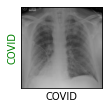

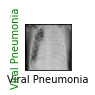

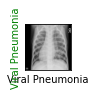

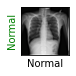

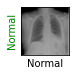

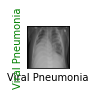

In [ ]:
images,labels = next(iter(train_loader))
show_image(images, labels,labels)

In [ ]:
# Using the pretrained ResNet model
resnet18 = torchvision.models.resnet18(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
# Changing to 4 output features
resnet18.fc = torch.nn.Linear(in_features = 512, out_features = 4)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam( resnet18.parameters(), lr = 3e-5)

In [ ]:
def show_preds():
  resnet18.eval()
  images,labels = next(iter(test_loader))
  outputs = resnet18(images)
  # print(outputs.shape)
  _,preds = torch.max(outputs,1)
  show_image(images,labels,preds)

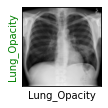

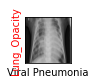

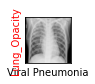

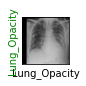

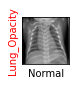

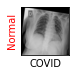

In [ ]:
show_preds()

In [ ]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.  #Not computing val_loss since we'll be evaluating the model multiple times within one epoch
        
        resnet18.train() # set model to training phase
        
        for train_step, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            #Once we get the loss we need to take a gradient step
            loss.backward() #Back propogation
            optimizer.step() #Completes the gradient step by updating all the parameter values(We are using all parameters)
            train_loss += loss.item() #Loss is a tensor which can't be added to train_loss so .item() converts it to float
            
            #Evaluating the model every 20th step
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(test_loader):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1) # 1 corresponds to the values and ) corresponds to the no of examples
                    accuracy += sum((preds == labels).numpy()) #adding correct preds to acc

                val_loss /= (val_step + 1) # 15 test batches so this logic gives the value for each step
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/10
Evaluating at step 0
Validation Loss: 1.6415, Accuracy: 0.3250


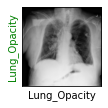

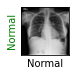

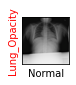

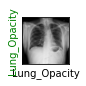

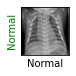

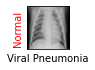

Evaluating at step 20
Validation Loss: 1.2694, Accuracy: 0.4167


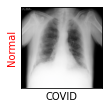

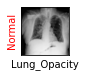

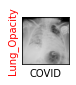

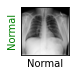

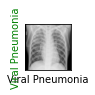

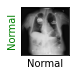

Evaluating at step 40
Validation Loss: 1.0024, Accuracy: 0.6417


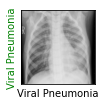

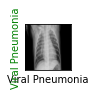

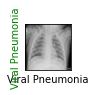

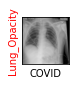

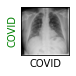

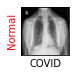

Evaluating at step 60
Validation Loss: 0.7164, Accuracy: 0.7500


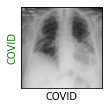

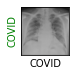

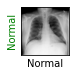

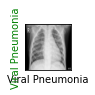

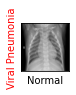

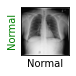

Evaluating at step 80
Validation Loss: 0.6730, Accuracy: 0.7083


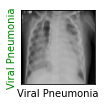

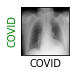

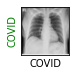

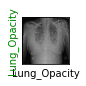

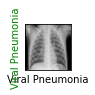

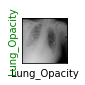

Evaluating at step 100
Validation Loss: 0.6741, Accuracy: 0.6833


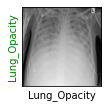

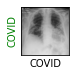

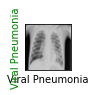

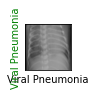

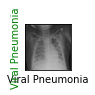

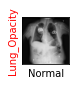

Evaluating at step 120
Validation Loss: 0.4775, Accuracy: 0.8333


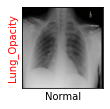

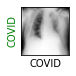

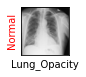

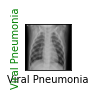

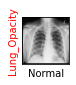

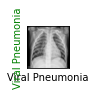

Evaluating at step 140
Validation Loss: 0.4840, Accuracy: 0.8500


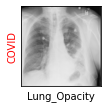

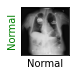

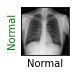

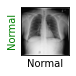

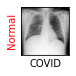

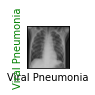

Evaluating at step 160
Validation Loss: 0.4763, Accuracy: 0.7917


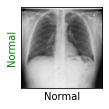

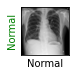

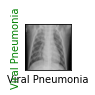

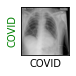

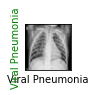

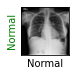

Evaluating at step 180
Validation Loss: 0.4668, Accuracy: 0.8000


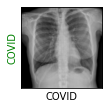

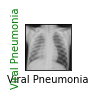

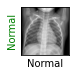

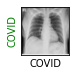

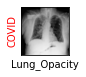

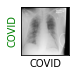

Evaluating at step 200
Validation Loss: 0.3641, Accuracy: 0.8583


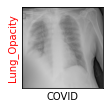

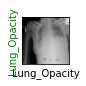

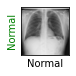

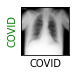

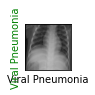

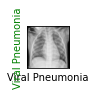

Evaluating at step 220
Validation Loss: 0.4474, Accuracy: 0.8917


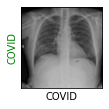

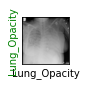

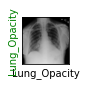

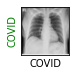

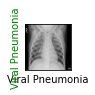

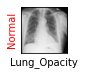

Evaluating at step 240
Validation Loss: 0.3348, Accuracy: 0.8833


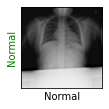

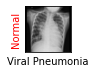

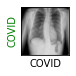

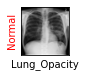

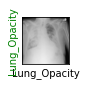

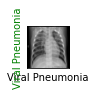

Evaluating at step 260
Validation Loss: 0.3751, Accuracy: 0.8833


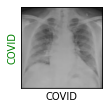

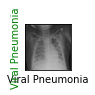

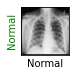

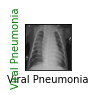

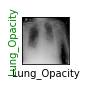

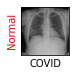

Evaluating at step 280
Validation Loss: 0.4353, Accuracy: 0.8250


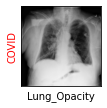

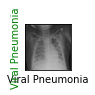

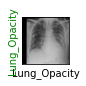

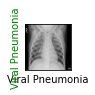

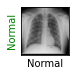

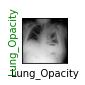

Evaluating at step 300
Validation Loss: 0.3957, Accuracy: 0.8583


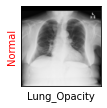

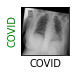

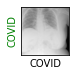

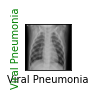

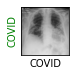

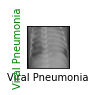

Evaluating at step 320
Validation Loss: 0.3836, Accuracy: 0.8667


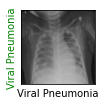

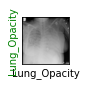

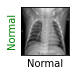

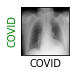

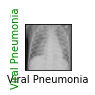

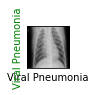

Evaluating at step 340
Validation Loss: 0.4137, Accuracy: 0.8667


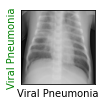

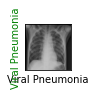

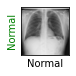

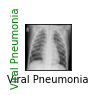

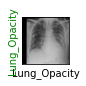

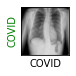

Evaluating at step 360
Validation Loss: 0.2546, Accuracy: 0.9083


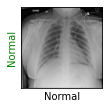

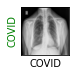

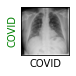

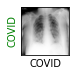

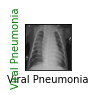

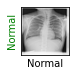

Evaluating at step 380
Validation Loss: 0.3775, Accuracy: 0.8417


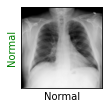

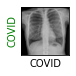

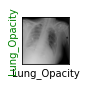

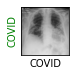

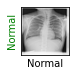

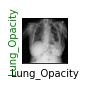

Evaluating at step 400
Validation Loss: 0.3279, Accuracy: 0.8833


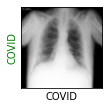

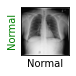

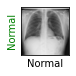

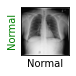

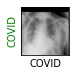

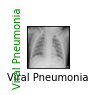

Evaluating at step 420
Validation Loss: 0.4331, Accuracy: 0.8417


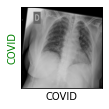

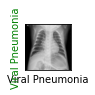

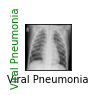

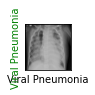

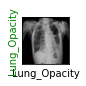

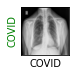

Evaluating at step 440
Validation Loss: 0.3509, Accuracy: 0.8750


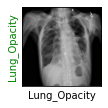

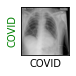

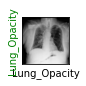

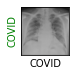

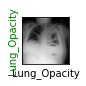

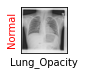

Evaluating at step 460
Validation Loss: 0.2803, Accuracy: 0.9167


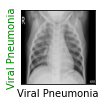

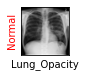

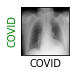

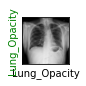

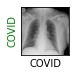

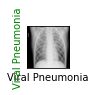

Evaluating at step 480
Validation Loss: 0.3702, Accuracy: 0.8833


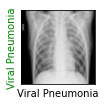

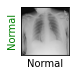

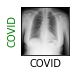

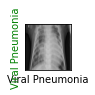

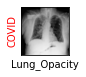

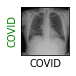

Evaluating at step 500
Validation Loss: 0.3316, Accuracy: 0.9167


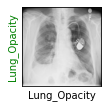

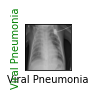

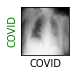

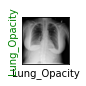

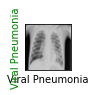

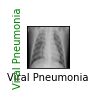

Evaluating at step 520
Validation Loss: 0.3804, Accuracy: 0.9083


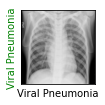

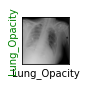

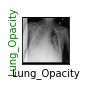

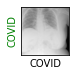

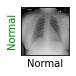

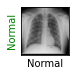

Evaluating at step 540
Validation Loss: 0.1942, Accuracy: 0.9500


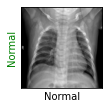

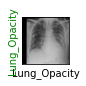

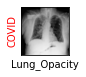

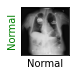

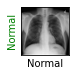

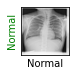

Performance condition satisfied, stopping..
CPU times: user 15min 48s, sys: 34.9 s, total: 16min 23s
Wall time: 16min 4s


In [ ]:
%%time

train(epochs=10)

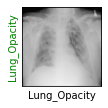

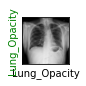

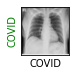

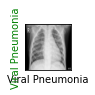

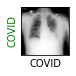

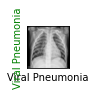

In [ ]:
show_preds()

In [ ]:
def save_model(state, filename = 'my_model.pth.tor' ):
    print ("Saving model")
    torch.save(state, filename)

In [ ]:
my_model = {'model': resnet18.state_dict(),'optimizer': optimizer.state_dict()}
save_model(my_model)
        

Saving model
